## _*H2 energy plot comparing full to particle hole transformations*_

This notebook demonstrates using Qiskit Chemistry to plot graphs of the ground state energy of the Hydrogen (H2) molecule over a range of inter-atomic distances using VQE and UCCSD with full and particle hole transformations. It is compared to the same energies as computed by the ExactEigensolver

This notebook populates a dictionary, that is a progammatic representation of an input file, in order to drive the Qiskit Chemistry stack. Such a dictionary can be manipulated programmatically and this is indeed the case here where we alter the molecule supplied to the driver in each loop.

This notebook has been written to use the PYQUANTE chemistry driver. See the PYQUANTE chemistry driver readme if you need to install the external PyQuante2 library that this driver requires.

In [1]:
import numpy as np
import pylab
from qiskit.chemistry import QiskitChemistry

# Input dictionary to configure Qiskit Chemistry for the chemistry problem.
qiskit_chemistry_dict = {
    'problem': {'random_seed': 50},
    'driver': {'name': 'PYQUANTE'},
    'PYQUANTE': {'atoms': '', 'basis': 'sto3g'},
    'operator': {'name': 'hamiltonian', 'qubit_mapping': 'jordan_wigner',
                 'two_qubit_reduction': False},
    'algorithm': {'name': ''}
}
molecule = 'H .0 .0 -{0}; H .0 .0 {0}'
algorithms = ['VQE', 'ExactEigensolver']
transformations = ['full', 'particle_hole']

start = 0.5  # Start distance
by    = 0.5  # How much to increase distance by
steps = 20   # Number of steps to increase by
energies = np.empty([len(transformations), len(algorithms), steps+1])
hf_energies = np.empty(steps+1)
distances = np.empty(steps+1)
eval_counts = np.empty([len(transformations), steps+1])

print('Processing step __', end='')
for i in range(steps+1):
    print('\b\b{:2d}'.format(i), end='', flush=True)
    d = start + i*by/steps
    qiskit_chemistry_dict['PYQUANTE']['atoms'] = molecule.format(d/2) 
    for j in range(len(algorithms)):
        qiskit_chemistry_dict['algorithm']['name'] = algorithms[j] 
        if algorithms[j] == 'ExactEigensolver':
            if 'optimizer' in qiskit_chemistry_dict:
                del qiskit_chemistry_dict['optimizer']
            if 'variational_form' in qiskit_chemistry_dict:
                del qiskit_chemistry_dict['variational_form']
            if 'initial_state' in qiskit_chemistry_dict:
                del qiskit_chemistry_dict['initial_state']
        else:
            qiskit_chemistry_dict['optimizer'] = {'name': 'COBYLA', 'maxiter': 10000 }
            qiskit_chemistry_dict['variational_form'] = {'name': 'UCCSD'}
            qiskit_chemistry_dict['initial_state'] = {'name': 'HartreeFock'}
            
        for k in range(len(transformations)):
            qiskit_chemistry_dict['operator']['transformation'] = transformations[k] 
            solver = QiskitChemistry()
            result = solver.run(qiskit_chemistry_dict)
            energies[k][j][i] = result['energy']
            hf_energies[i] = result['hf_energy']
            if algorithms[j] == 'VQE':
                eval_counts[k][i] = result['algorithm_retvals']['eval_count']
    distances[i] = d
print(' --- complete')

print('Distances: ', distances)
print('Energies:', energies)
print('Hartree-Fock energies:', hf_energies)
print('VQE num evaluations:', eval_counts)


Processing step 20 --- complete
Distances:  [0.5   0.525 0.55  0.575 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775
 0.8   0.825 0.85  0.875 0.9   0.925 0.95  0.975 1.   ]
Energies: [[[-1.05515973 -1.07591359 -1.09262986 -1.105918   -1.11628597
   -1.12416088 -1.12990475 -1.1338262  -1.13618942 -1.13722134
   -1.13711707 -1.13604434 -1.13414766 -1.1315512  -1.12836187
   -1.12467173 -1.12056027 -1.11609624 -1.11133942 -1.10634211
   -1.10115033]
  [-1.05515974 -1.07591361 -1.09262987 -1.10591802 -1.11628599
   -1.12416089 -1.12990476 -1.1338262  -1.13618944 -1.13722136
   -1.13711707 -1.13604436 -1.13414767 -1.13155121 -1.12836188
   -1.12467175 -1.12056028 -1.11609624 -1.11133943 -1.10634212
   -1.10115034]]

 [[-1.05515973 -1.07591359 -1.09262987 -1.105918   -1.11628598
   -1.12416087 -1.12990474 -1.13382619 -1.13618943 -1.13722134
   -1.13711704 -1.13604435 -1.13414766 -1.13155119 -1.12836186
   -1.12467175 -1.12056028 -1.11609624 -1.11133942 -1.1063421
   -1.10115033]
  [-1.055159

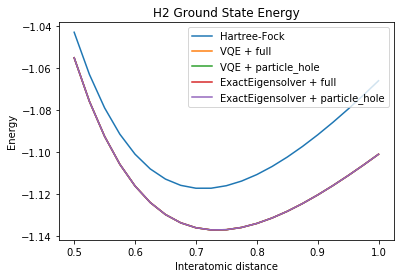

In [5]:
pylab.plot(distances, hf_energies, label='Hartree-Fock')
for j in range(len(algorithms)):
    for k in range(len(transformations)):
        pylab.plot(distances, energies[k][j], label=algorithms[j]+' + '+transformations[k])
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('H2 Ground State Energy')
pylab.legend(loc='upper right');

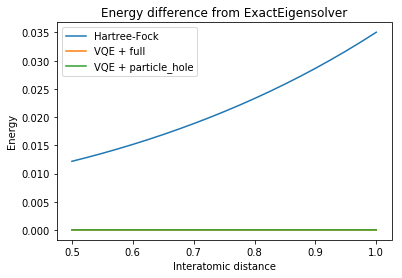

In [6]:
pylab.plot(distances, np.subtract(hf_energies, energies[0][1]), label='Hartree-Fock')
for k in range(len(transformations)):
    pylab.plot(distances, np.subtract(energies[k][0], energies[k][1]), label='VQE + '+transformations[k])
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('Energy difference from ExactEigensolver')
pylab.legend(loc='upper left');

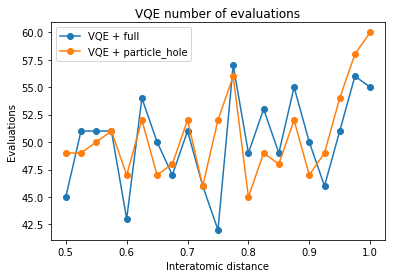

In [7]:
for k in range(len(transformations)):
    pylab.plot(distances, eval_counts[k], '-o', label='VQE + ' + transformations[k])
pylab.xlabel('Interatomic distance')
pylab.ylabel('Evaluations')
pylab.title('VQE number of evaluations')
pylab.legend(loc='upper left');